In [1]:
from openfermion.hamiltonians import MolecularData, load_molecular_hamiltonian
from openfermion.ops import FermionOperator
from openfermion.transforms import bravyi_kitaev
from openfermion.utils import hermitian_conjugated
from openfermion.ops import QubitOperator
from forestopenfermion import pyquilpauli_to_qubitop, qubitop_to_pyquilpauli
from pyquil.paulis import PauliSum
from pyquil.api import WavefunctionSimulator
from scipy.optimize import minimize
from pyquil import Program
from pyquil.gates import *

import numpy as np
import functools

import matplotlib.pyplot as plt
%matplotlib inline

from openfermion.utils import uccsd_generator
from forestopenfermion import exponentiate


In [2]:
sim = WavefunctionSimulator()
numQubit = 12
class Track:
    def __init__(self):
        self.cnt = 0
        
        
def solve_vqe_ucc_LiH(hamiltonian: PauliSum, degree) -> float:
    # Construct a variational quantum eigensolver solution to find the lowest
    # eigenvalue of the given hamiltonian
    
    # degree 1: up to T_1
    # degree 2: up to T_2
    
    numParams = 0
    if degree == 1:
        numParams = 16
    elif degree == 2:
        numParams = 16+64+12
    params_init = np.random.rand(numParams)*0.5-0.25
    
    track = Track()

    def inc(t, xk):
        t.cnt += 1
    
    
    def ansatz_energy(params):
        p = None
        p = Program()
        
        # Reference state
        p += X(0)
        p += X(2)
        
        single_amp = []
        double_amp = []
        
        # occupied: 0,1,2,3 unoccupied: rest
        for i in range(4):
            single_amp.append([[2*i+4, 0], params[4*i]])
            single_amp.append([[2*i+5, 1], params[4*i+1]])
            single_amp.append([[2*i+4, 2], params[4*i+2]])
            single_amp.append([[2*i+5, 3], params[4*i+3]])
            
        if degree == 2:
            for i in range(4):
                for j in range(4):
                    double_amp.append([[2*i+4, 0, 2*j+5, 1], params[16+(4*i+j)*4]])
                    double_amp.append([[2*i+4, 0, 2*j+5, 3], params[16+(4*i+j)*4+1]])
                    double_amp.append([[2*i+4, 2, 2*j+5, 1], params[16+(4*i+j)*4+2]])
                    double_amp.append([[2*i+4, 2, 2*j+5, 3], params[16+(4*i+j)*4+3]])
                    
            count = 0
            for i in range(3):
                for j in range(i+1, 4):
                    double_amp.append([[2*i+4, 0, 2*j+4, 2], params[16+64+count]])
                    count += 1
                    double_amp.append([[2*i+5, 1, 2*j+5, 3], params[16+64+count]])
                    count += 1
                    
                    
        '''
        # occupied: 0,1,2,4 unoccupied: rest
        for i in range(3):
            single_amp.append([[2*i+6, 0], params[3*i]])
            single_amp.append([[2*i+6, 2], params[3*i+1]])
            single_amp.append([[2*i+6, 4], params[3*i+2]])
        for i in range(5):
            single_amp.append([[2*i+3, 1], params[9+i]])
            
        if degree == 2:
            for i in range(4):
                for j in range(4):
                    double_amp.append([[2*i+4, 0, 2*j+5, 1], params[16+(4*i+j)*4]])
                    double_amp.append([[2*i+4, 0, 2*j+5, 3], params[16+(4*i+j)*4+1]])
                    double_amp.append([[2*i+4, 2, 2*j+5, 1], params[16+(4*i+j)*4+2]])
                    double_amp.append([[2*i+4, 2, 2*j+5, 3], params[16+(4*i+j)*4+3]])        
        '''
        
        ucc_gen = uccsd_generator(single_amp, double_amp)
        try:
            ucc_program = exponentiate(ucc_gen_qubitop/(-1j))
        except:
            ucc_program = I(0)
        p += ucc_program

        energy = sim.expectation(p, hamiltonian).real
        return energy

    params_answer = minimize(ansatz_energy, params_init, method='L-BFGS-B', callback=functools.partial(inc, track)).x
    return ansatz_energy(params_answer), track.cnt

In [3]:
def get_ground_energy_ucc_LiH(interaction_hamil, degree):
    fermionop_hamil = FermionOperator()
    for key in interaction_hamil:
        value = interaction_hamil[key]
        fermionop_hamil += FermionOperator(term=key, coefficient=value)
        
    qubitop_hamil = bravyi_kitaev(fermionop_hamil)
    pauliop_hamil = qubitop_to_pyquilpauli(qubitop_hamil)
    
    sim = WavefunctionSimulator()
    return solve_vqe_ucc_LiH(pauliop_hamil, degree)


In [4]:
basis = 'sto-3g'
multiplicity = 1  # 2S+1
charge = 0

import matplotlib.pyplot as plt
%matplotlib inline

bond_lengths = np.linspace(0.3, 2.5, 23)
vqe_ground_energies = []
vqe_iter_mean = []
vqe_iter_std = []

for degree in [1,2]:
    gelist = []
    iterlist = []
    for bond_length in bond_lengths:
        geometry = [('H', (0., 0., 0.)), ('Li', (0., 0., bond_length))]
        description = str(round(bond_length, 2))
        LiH_interaction_hamil = load_molecular_hamiltonian(geometry,
            basis,
            multiplicity,
            description,
            n_active_electrons=None,
            n_active_orbitals=None)

        ge, cnt = get_ground_energy_ucc_LiH(LiH_interaction_hamil, degree)
        print('bond length: ', round(bond_length, 2), ' ground state energy: ', ge, ' iteration: ', cnt)
        gelist.append(ge)
        iterlist.append(cnt)
        
    vqe_ground_energies.append(gelist)
    vqe_iter_mean.append(np.mean(iterlist))
    vqe_iter_std.append(np.std(iterlist))


bond length:  0.3  ground state energy:  -5.842436832348322  iteration:  0
bond length:  0.4  ground state energy:  -6.610258945101443  iteration:  0
bond length:  0.5  ground state energy:  -7.028410095318577  iteration:  0
bond length:  0.6  ground state energy:  -7.299541051973023  iteration:  0
bond length:  0.7  ground state energy:  -7.485944871059216  iteration:  0
bond length:  0.8  ground state energy:  -7.615770161648717  iteration:  0
bond length:  0.9  ground state energy:  -7.7057533404568685  iteration:  0
bond length:  1.0  ground state energy:  -7.767362135986515  iteration:  0
bond length:  1.1  ground state energy:  -7.8087431766666615  iteration:  0
bond length:  1.2  ground state energy:  -7.835615825676278  iteration:  0
bond length:  1.3  ground state energy:  -7.8519538580329495  iteration:  0
bond length:  1.4  ground state energy:  -7.860538661057047  iteration:  0
bond length:  1.5  ground state energy:  -7.863357621538313  iteration:  0
bond length:  1.6  gro

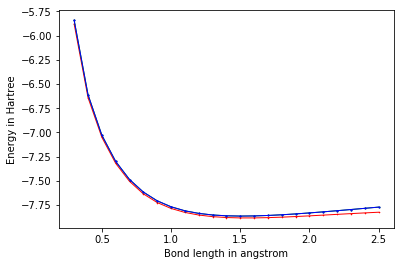

In [6]:
# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
bond_lengths = []
for bond_length in np.linspace(0.3, 2.5, 23):
    bond_lengths += [bond_length]
    description = str(round(bond_length,2))
#    print(description)
    geometry = [('H', (0., 0., 0.)), ('Li', (0., 0., bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity, description=description)
    
    # Load data.
    molecule.load()
    fci_energies += [molecule.fci_energy]

plt.figure(0)
plt.plot(bond_lengths, fci_energies, 'rx-', linewidth=1, markersize=1)
plt.plot(bond_lengths, vqe_ground_energies[0], 'go-', linewidth=1, markersize=1)
plt.plot(bond_lengths, vqe_ground_energies[1], 'bo-', linewidth=1, markersize=1)
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()